<a href="https://colab.research.google.com/github/aylinkarapanar/fake_news/blob/main/Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# test different training & evaluation splits
# TF-IDF, Word2Vec, BERT embeddings in combination with KNN and SVM

# Downloads & Installs

In [4]:
!pip install langdetect
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install openTSNE

In [5]:
import pandas as pd
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import torch
import os
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, EarlyStoppingCallback,
                          Trainer, TrainingArguments)
from datasets import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform
import openTSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform

In [3]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
# Go to Runtime and change the runtime type to T4 GPU for extracting BERT embeddings
# with GPU, total time for processing 100 samples: 3.08 seconds
# with CPU, total time for processing 100 samples: 130.41 seconds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data

In [6]:
os.chdir('/content/drive/My Drive/')

In [ ]:
data = pd.read_csv("WELFake_Dataset.csv")
data = data.fillna('')

In [ ]:
data.head()
# Note: (0 = real and 1 = fake)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Labeling Issue (NYT & Reuters)

In [ ]:
nyt_articles = data[data['title'].str.contains("The New York Times$", na=False)]
nyt_label_counts = nyt_articles['label'].value_counts()

In [ ]:
print(nyt_label_counts)

0    6223
1       1
Name: label, dtype: int64


In [ ]:
total_label_counts = data['label'].value_counts()
print(total_label_counts)
# In the data card, it is stated that: "72,134 news articles with 35,028 real and 37,106 fake news"
# However, the label counts are for 1 (real according to the authors), 37106 and for 0 (fake according to the authors) 35028.
# The labels should be inversed.

1    37106
0    35028
Name: label, dtype: int64


## Different Languages

In [ ]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

data['language'] = data.apply(lambda row: detect_language(row['title'] + " " + row['text']), axis=1)

language_counts = data['language'].value_counts()

In [ ]:
print(language_counts)

language
en         71540
ru           156
es           141
de           132
fr            72
ar            19
unknown       10
pt             9
it             7
tr             7
id             5
so             4
hr             4
nl             4
no             3
ro             3
pl             2
da             2
el             2
cy             2
ca             1
hu             1
zh-cn          1
sv             1
et             1
tl             1
sw             1
vi             1
fi             1
lt             1
Name: count, dtype: int64


In [ ]:
label_language_counts = data.groupby('language')['label'].value_counts().unstack().fillna(0)

In [ ]:
print(label_language_counts)

label           0        1
language                  
ar            0.0     19.0
ca            0.0      1.0
cy            0.0      2.0
da            0.0      2.0
de            0.0    132.0
el            0.0      2.0
en        35027.0  36513.0
es            0.0    141.0
et            0.0      1.0
fi            0.0      1.0
fr            1.0     71.0
hr            0.0      4.0
hu            0.0      1.0
id            0.0      5.0
it            0.0      7.0
lt            0.0      1.0
nl            0.0      4.0
no            0.0      3.0
pl            0.0      2.0
pt            0.0      9.0
ro            0.0      3.0
ru            0.0    156.0
so            0.0      4.0
sv            0.0      1.0
sw            0.0      1.0
tl            0.0      1.0
tr            0.0      7.0
unknown       0.0     10.0
vi            0.0      1.0
zh-cn         0.0      1.0


In [ ]:
en_data = data[data['language'] == 'en']

en_data.to_csv('/content/drive/My Drive/english_articles.csv', index=False)

In [7]:
en_data = pd.read_csv('english_articles.csv')
en_data = en_data.fillna('')

In [8]:
def normalise(example):
        return ' '.join(example.split())

for entry in ['title', 'text']:
    en_data[entry] = en_data[entry].astype(str).transform(normalise)

en_data[['title', 'text']].head()

,title,text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...
1,,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last n..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will..."


In [ ]:
en_data.head()

,Unnamed: 0,title,text,label,language
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,en
1,1,NaN,Did they post their votes for Hillary already?,1,en
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,en
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,en
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,en


#BERT

## Time calculation

In [ ]:
len(en_data)

71540

In [ ]:
data_sample = en_data[:100]

In [ ]:
import time

# Combine title and text for each sample
combined_texts = (data_sample['title'] + " " + data_sample['text']).tolist()

# Step 2: Tokenization and Encoding
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def batch_tokenize(texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        yield tokenizer(texts[i:i + batch_size], padding=True, truncation=True, return_tensors='pt', max_length=512)

# Step 4: Generate BERT Embeddings
model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)

def get_embeddings(batch_tokenizer, batch_size=32):
    model.eval()
    embeddings = []

    for batch in batch_tokenizer:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            start_time = time.time()
            outputs = model(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)
            end_time = time.time()

            print(f"Processed batch with {input_ids.shape[0]} samples in {(end_time - start_time):.2f} seconds")

    return np.concatenate(embeddings, axis=0)

# Tokenize and get embeddings in batches
try:
    start_time = time.time()
    batch_tokenizer = batch_tokenize(combined_texts, batch_size=32)
    embeddings = get_embeddings(batch_tokenizer, batch_size=32)
    end_time = time.time()

    print(f"Total time for processing {len(combined_texts)} samples: {(end_time - start_time):.2f} seconds")
    print(f"Generated embeddings: {embeddings.shape}")
except Exception as e:
    print(f"Error generating embeddings: {e}")

# Step 3: Split the Data after getting embeddings
try:
    train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
        embeddings,
        data_sample['label'],
        test_size=0.2,
        random_state=1,
        stratify= data_sample['label']  # Stratify split
    )
    print(f"Data split: {train_embeddings.shape}, {test_embeddings.shape}")
except Exception as e:
    print(f"Error during train/test split: {e}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Processed batch with 32 samples in 51.11 seconds
Processed batch with 32 samples in 36.06 seconds
Processed batch with 32 samples in 38.68 seconds
Processed batch with 4 samples in 4.11 seconds
Total time for processing 100 samples: 130.41 seconds
Generated embeddings: (100, 768)
Data split: (80, 768), (20, 768)


## BERT & KNN

In [9]:
# Combine title and text
combined_texts = (en_data['title'] + " " + en_data['text']).tolist()

# Initialize tokenizer from distilBERT model (faster and more compact than BERT)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Define batch tokenize function for tokenizing texts in batches
def batch_tokenize(texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        yield tokenizer(texts[i:i + batch_size], padding=True, truncation=True, return_tensors='pt', max_length=512)

# Generate BERT Embeddings
model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)

def get_embeddings(token_batches, batch_size=32):
    model.eval()
    embeddings = []

    # Disable gradient calculation to reduce memory usage
    # Move input_ids and attention_mask to device (GPU) instead of CPU (default)
    for batch in token_batches:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.concatenate(embeddings, axis=0)

# Tokenize and get embeddings in batches
embeddings = get_embeddings(batch_tokenize(combined_texts, batch_size=32), batch_size=32)

embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = en_data['label'].values
embeddings_path = '/content/drive/My Drive/embeddings.parquet'
embeddings_df.to_parquet(embeddings_path)


Generated embeddings: (71540, 768)


/usr/local/lib/python3.10/dist-packages/pandas/io/parquet.py:159: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [9]:
embeddings_df = pd.read_parquet('embeddings.parquet')

In [8]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-0.037381,0.017130,0.230371,-0.029941,0.193693,-0.090889,0.104744,0.495729,-0.241823,-0.109363,...,-0.069670,0.045403,-0.247831,-0.143979,-0.138096,-0.080375,-0.090370,0.095634,-0.183093,1
1,0.134851,-0.052254,0.195594,0.195084,0.231228,-0.045875,-0.059769,-0.012652,-0.031182,0.012770,...,0.162820,-0.005800,-0.232787,0.088659,-0.108625,0.307964,0.009557,-0.028832,0.135540,1
2,0.218392,-0.250414,0.255919,-0.014318,0.150582,-0.191891,0.172437,0.143032,-0.146205,-0.003432,...,0.038357,0.027828,-0.144345,0.016996,-0.075235,0.086844,-0.173914,-0.131144,-0.168667,1
3,-0.263380,-0.077555,0.178118,-0.064642,0.219602,-0.088452,0.105203,0.367690,0.058200,-0.043577,...,-0.010409,0.095923,-0.173587,0.024981,-0.286040,0.015423,0.061175,0.125817,-0.124797,0
4,-0.208710,0.059987,0.185885,0.043857,0.102636,-0.119286,0.097424,0.186917,0.054725,-0.075660,...,0.024222,0.199448,-0.284789,0.063785,-0.301365,0.146767,-0.085565,0.106535,-0.020653,1


In [10]:
embeddings = embeddings_df.drop(columns=['label']).values
print(embeddings.shape)

(71540, 768)


In [13]:
labels = embeddings_df['label'].values
print(labels[:5])

[1 1 1 0 1]


In [15]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
        embeddings, labels,
        test_size = 0.2,
        random_state = 1,
        stratify = labels
    )

In [17]:
train_embeddings

array([[-0.11004872, -0.02421575,  0.19831093, ..., -0.08758042,
         0.09894279,  0.18740848],
       [-0.17499375, -0.03538219,  0.16316248, ..., -0.13621756,
         0.1084911 ,  0.01725655],
       [-0.1592859 ,  0.18334839,  0.12713084, ..., -0.11005163,
         0.1285316 ,  0.10310949],
       ...,
       [-0.35046726, -0.093739  ,  0.21595526, ..., -0.06474359,
         0.19502443, -0.05708507],
       [-0.2583636 , -0.07308325,  0.11726974, ..., -0.10296006,
        -0.0512571 ,  0.11483064],
       [-0.00882288, -0.01631181,  0.26309568, ..., -0.04894529,
        -0.00450918,  0.05741265]], dtype=float32)

In [17]:
opt = RandomizedSearchCV(
                KNeighborsClassifier(),
                {'n_neighbors': [3, 5, 11, 13],
                 'weights': ['uniform', 'distance'],
                 'metric': ['euclidean', 'cosine', 'minkowski']},
                n_jobs = 1,
                refit = False,
                verbose = 1000,
                random_state = 1,
                n_iter = 10
            ).fit(train_embeddings, train_labels)

clf = KNeighborsClassifier(
metric = opt.best_params_['metric'],
n_neighbors = opt.best_params_['n_neighbors'],
weights = opt.best_params_['weights']).fit(train_embeddings, train_labels)
preds = clf.predict(test_embeddings)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START metric=cosine, n_neighbors=11, weights=distance............
[CV 1/5; 1/10] END metric=cosine, n_neighbors=11, weights=distance;, score=0.935 total time=  27.0s
[CV 2/5; 1/10] START metric=cosine, n_neighbors=11, weights=distance............
[CV 2/5; 1/10] END metric=cosine, n_neighbors=11, weights=distance;, score=0.933 total time=  45.4s
[CV 3/5; 1/10] START metric=cosine, n_neighbors=11, weights=distance............
[CV 3/5; 1/10] END metric=cosine, n_neighbors=11, weights=distance;, score=0.933 total time=  39.9s
[CV 4/5; 1/10] START metric=cosine, n_neighbors=11, weights=distance............
[CV 4/5; 1/10] END metric=cosine, n_neighbors=11, weights=distance;, score=0.933 total time=  24.2s
[CV 5/5; 1/10] START metric=cosine, n_neighbors=11, weights=distance............
[CV 5/5; 1/10] END metric=cosine, n_neighbors=11, weights=distance;, score=0.935 total time=  24.4s
[CV 1/5; 2/10] START metric=minkow

In [18]:
opt.best_params_

{'weights': 'distance', 'n_neighbors': 11, 'metric': 'cosine'}

In [18]:
clf = KNeighborsClassifier(metric = 'cosine', n_neighbors = 11, weights = 'distance' ).fit(train_embeddings, train_labels)
preds = clf.predict(test_embeddings)

In [19]:
print(classification_report(test_labels, preds))
accuracy_score(test_labels, preds)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7005
           1       0.94      0.95      0.94      7303

    accuracy                           0.94     14308
   macro avg       0.94      0.94      0.94     14308
weighted avg       0.94      0.94      0.94     14308



0.9386357282639083

<Figure size 800x600 with 0 Axes>

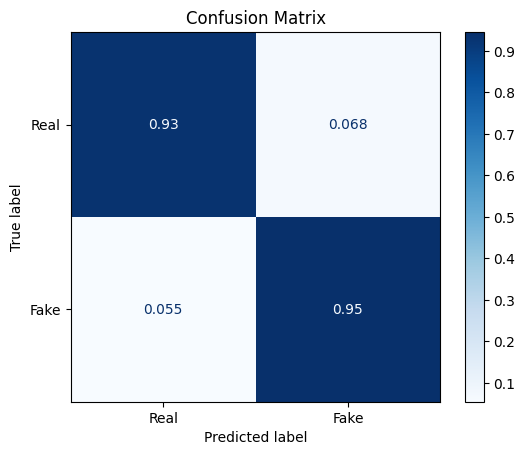

In [20]:
# Compute confusion matrix and normalize
cm = confusion_matrix(test_labels, preds, normalize='true')

# Define class names (0: Real, 1: Fake)
class_names = ['Real', 'Fake']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

output_path = '/content/drive/My Drive/confusion_matrix_bert_knn.png'
plt.savefig(output_path)

plt.show()


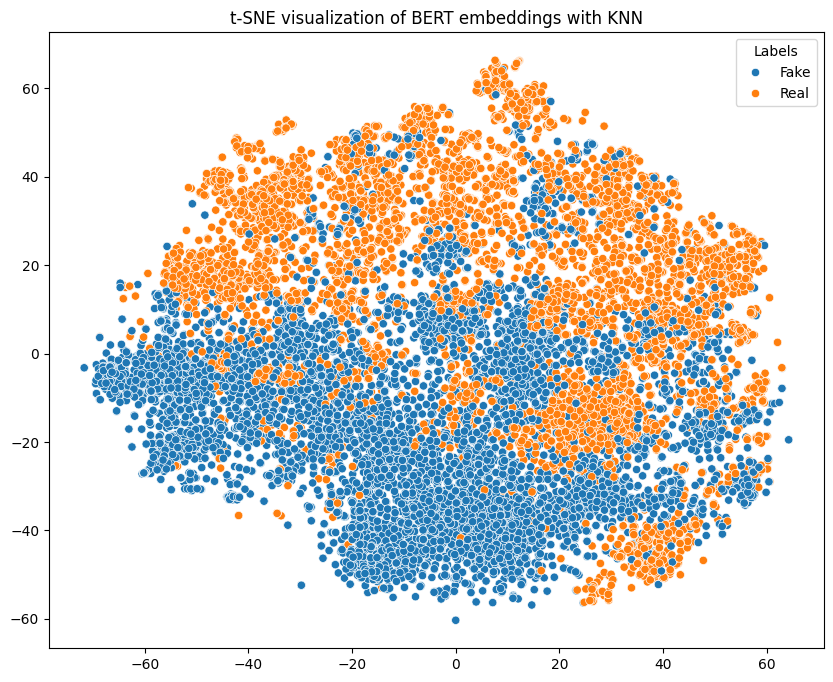

In [22]:
tsne = openTSNE.TSNE(n_components=2, initialization="random", perplexity=30, n_iter=300, random_state = 1)
test_embeddings_2D = tsne.fit(test_embeddings)

class_names = ['Real', 'Fake']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_embeddings_2D[:, 0], y=test_embeddings_2D[:, 1], hue=[class_names[id] for id in preds])
plt.title('t-SNE visualization of BERT embeddings with KNN')
plt.legend(title='Labels')
bert_knn_path = '/content/drive/My Drive/bert_knn.png'
plt.savefig(bert_knn_path)
plt.show()

## BERT & SVM

In [24]:
opt = RandomizedSearchCV(
    make_pipeline(StandardScaler(), LinearSVC()),
        {
            'linearsvc__C': loguniform(1e-6, 1e+6),
            'linearsvc__class_weight': [None, 'balanced']
        },
        scoring='f1_micro',
        cv=StratifiedKFold(5, shuffle = True),
        n_iter = 20,
        n_jobs = 1,
        verbose = 1000,
        random_state = 1,
        refit = True,
        return_train_score = True
    ).fit(train_embeddings, train_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START linearsvc__C=0.10098667109352932, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 1/20] END linearsvc__C=0.10098667109352932, linearsvc__class_weight=None;, score=(train=0.959, test=0.950) total time= 1.0min
[CV 2/5; 1/20] START linearsvc__C=0.10098667109352932, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 1/20] END linearsvc__C=0.10098667109352932, linearsvc__class_weight=None;, score=(train=0.957, test=0.954) total time=  56.4s
[CV 3/5; 1/20] START linearsvc__C=0.10098667109352932, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 1/20] END linearsvc__C=0.10098667109352932, linearsvc__class_weight=None;, score=(train=0.958, test=0.952) total time=  56.6s
[CV 4/5; 1/20] START linearsvc__C=0.10098667109352932, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 1/20] END linearsvc__C=0.10098667109352932, linearsvc__class_weight=None;, score=(train=0.958, test=0.953) total time=  55.8s
[CV 5/5; 1/20] START linearsvc__C=0.10098667109352932, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 1/20] END linearsvc__C=0.10098667109352932, linearsvc__class_weight=None;, score=(train=0.958, test=0.953) total time=  54.8s
[CV 1/5; 2/20] START linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 2/20] END linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced;, score=(train=0.933, test=0.927) total time= 1.6min
[CV 2/5; 2/20] START linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 2/20] END linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced;, score=(train=0.935, test=0.930) total time= 1.6min
[CV 3/5; 2/20] START linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 2/20] END linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced;, score=(train=0.928, test=0.920) total time= 1.9min
[CV 4/5; 2/20] START linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 2/20] END linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced;, score=(train=0.934, test=0.931) total time= 1.7min
[CV 5/5; 2/20] START linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 2/20] END linearsvc__C=155127.3280140012, linearsvc__class_weight=balanced;, score=(train=0.934, test=0.929) total time= 1.6min
[CV 1/5; 3/20] START linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced
[CV 1/5; 3/20] END linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced;, score=(train=0.957, test=0.949) total time=  13.4s
[CV 2/5; 3/20] START linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced
[CV 2/5; 3/20] END linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced;, score=(train=0.956, test=0.952) total time=  13.2s
[CV 3/5; 3/20] START linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced
[CV 3/5; 3/20] END linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced;, score=(train=0.956, test=0.952) total time=  13.9s
[CV 4/5; 3/20] START linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced
[CV 4/5; 3/20] END linearsvc__C=0.004246106389788912, linearsvc__class_weight=balanced;

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 6/20] END linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced;, score=(train=0.912, test=0.909) total time= 1.6min
[CV 2/5; 6/20] START linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 6/20] END linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced;, score=(train=0.937, test=0.931) total time= 1.6min
[CV 3/5; 6/20] START linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 6/20] END linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced;, score=(train=0.937, test=0.932) total time= 1.6min
[CV 4/5; 6/20] START linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 6/20] END linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced;, score=(train=0.928, test=0.921) total time= 1.6min
[CV 5/5; 6/20] START linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 6/20] END linearsvc__C=108.88108542130334, linearsvc__class_weight=balanced;, score=(train=0.931, test=0.928) total time= 1.8min
[CV 1/5; 7/20] START linearsvc__C=2.9228115040559146, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 7/20] END linearsvc__C=2.9228115040559146, linearsvc__class_weight=None;, score=(train=0.938, test=0.933) total time= 1.6min
[CV 2/5; 7/20] START linearsvc__C=2.9228115040559146, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 7/20] END linearsvc__C=2.9228115040559146, linearsvc__class_weight=None;, score=(train=0.932, test=0.926) total time= 1.6min
[CV 3/5; 7/20] START linearsvc__C=2.9228115040559146, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 7/20] END linearsvc__C=2.9228115040559146, linearsvc__class_weight=None;, score=(train=0.950, test=0.946) total time= 1.6min
[CV 4/5; 7/20] START linearsvc__C=2.9228115040559146, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 7/20] END linearsvc__C=2.9228115040559146, linearsvc__class_weight=None;, score=(train=0.940, test=0.936) total time= 1.6min
[CV 5/5; 7/20] START linearsvc__C=2.9228115040559146, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 7/20] END linearsvc__C=2.9228115040559146, linearsvc__class_weight=None;, score=(train=0.928, test=0.924) total time= 1.6min
[CV 1/5; 8/20] START linearsvc__C=0.005744896425098713, linearsvc__class_weight=None
[CV 1/5; 8/20] END linearsvc__C=0.005744896425098713, linearsvc__class_weight=None;, score=(train=0.957, test=0.949) total time=  16.6s
[CV 2/5; 8/20] START linearsvc__C=0.005744896425098713, linearsvc__class_weight=None
[CV 2/5; 8/20] END linearsvc__C=0.005744896425098713, linearsvc__class_weight=None;, score=(train=0.957, test=0.953) total time=  16.3s
[CV 3/5; 8/20] START linearsvc__C=0.005744896425098713, linearsvc__class_weight=None
[CV 3/5; 8/20] END linearsvc__C=0.005744896425098713, linearsvc__class_weight=None;, score=(train=0.957, test=0.952) total time=  16.9s
[CV 4/5; 8/20] START linearsvc__C=0.005744896425098713, linearsvc__class_weight=None
[CV 4/5; 8/20] END linearsvc__C=0.005744896425098713, linearsvc__class_weight=None;, score=(train=0.957, test=0.952) t

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 11/20] END linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced;, score=(train=0.918, test=0.918) total time= 1.6min
[CV 2/5; 11/20] START linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 11/20] END linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced;, score=(train=0.938, test=0.933) total time= 1.7min
[CV 3/5; 11/20] START linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 11/20] END linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced;, score=(train=0.937, test=0.928) total time= 1.7min
[CV 4/5; 11/20] START linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 11/20] END linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced;, score=(train=0.943, test=0.939) total time= 1.7min
[CV 5/5; 11/20] START linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 11/20] END linearsvc__C=111.07341435984726, linearsvc__class_weight=balanced;, score=(train=0.936, test=0.930) total time= 1.7min
[CV 1/5; 12/20] START linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 12/20] END linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced;, score=(train=0.958, test=0.949) total time= 1.2min
[CV 2/5; 12/20] START linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 12/20] END linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced;, score=(train=0.957, test=0.954) total time= 1.2min
[CV 3/5; 12/20] START linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 12/20] END linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced;, score=(train=0.958, test=0.952) total time= 1.3min
[CV 4/5; 12/20] START linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 12/20] END linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced;, score=(train=0.957, test=0.952) total time= 1.2min
[CV 5/5; 12/20] START linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 12/20] END linearsvc__C=0.3065192087834554, linearsvc__class_weight=balanced;, score=(train=0.958, test=0.953) total time= 1.2min
[CV 1/5; 13/20] START linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None
[CV 1/5; 13/20] END linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None;, score=(train=0.932, test=0.924) total time=   3.2s
[CV 2/5; 13/20] START linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None
[CV 2/5; 13/20] END linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None;, score=(train=0.929, test=0.933) total time=   3.0s
[CV 3/5; 13/20] START linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None
[CV 3/5; 13/20] END linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None;, score=(train=0.931, test=0.928) total time=   2.7s
[CV 4/5; 13/20] START linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None
[CV 4/5; 13/20] END linearsvc__C=4.837748234822918e-05, linearsvc__class_weight=None;, score=(train

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 14/20] END linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced;, score=(train=0.942, test=0.932) total time= 1.7min
[CV 2/5; 14/20] START linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 14/20] END linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced;, score=(train=0.923, test=0.921) total time= 1.7min
[CV 3/5; 14/20] START linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 14/20] END linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced;, score=(train=0.937, test=0.930) total time= 1.7min
[CV 4/5; 14/20] START linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 14/20] END linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced;, score=(train=0.940, test=0.934) total time= 1.7min
[CV 5/5; 14/20] START linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 14/20] END linearsvc__C=2191.1435766978307, linearsvc__class_weight=balanced;, score=(train=0.945, test=0.937) total time= 1.7min
[CV 1/5; 15/20] START linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 15/20] END linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced;, score=(train=0.911, test=0.907) total time= 1.7min
[CV 2/5; 15/20] START linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 15/20] END linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced;, score=(train=0.933, test=0.931) total time= 1.7min
[CV 3/5; 15/20] START linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 15/20] END linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced;, score=(train=0.930, test=0.928) total time= 1.7min
[CV 4/5; 15/20] START linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 15/20] END linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced;, score=(train=0.941, test=0.938) total time= 1.7min
[CV 5/5; 15/20] START linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 15/20] END linearsvc__C=416043.6603416715, linearsvc__class_weight=balanced;, score=(train=0.941, test=0.937) total time= 1.7min
[CV 1/5; 16/20] START linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced
[CV 1/5; 16/20] END linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced;, score=(train=0.918, test=0.911) total time=   3.5s
[CV 2/5; 16/20] START linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced
[CV 2/5; 16/20] END linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced;, score=(train=0.916, test=0.919) total time=   2.9s
[CV 3/5; 16/20] START linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced
[CV 3/5; 16/20] END linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced;, score=(train=0.917, test=0.913) total time=   2.7s
[CV 4/5; 16/20] START linearsvc__C=1.2990016529070631e-05, linearsvc__class_weight=balanced
[CV 4/5; 16/20] END linearsvc__C=1.2990016529070631e-05, linearsv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 17/20] END linearsvc__C=32860.17163831699, linearsvc__class_weight=None;, score=(train=0.940, test=0.932) total time= 1.7min
[CV 2/5; 17/20] START linearsvc__C=32860.17163831699, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 17/20] END linearsvc__C=32860.17163831699, linearsvc__class_weight=None;, score=(train=0.922, test=0.920) total time= 1.7min
[CV 3/5; 17/20] START linearsvc__C=32860.17163831699, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 17/20] END linearsvc__C=32860.17163831699, linearsvc__class_weight=None;, score=(train=0.929, test=0.924) total time= 1.7min
[CV 4/5; 17/20] START linearsvc__C=32860.17163831699, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 17/20] END linearsvc__C=32860.17163831699, linearsvc__class_weight=None;, score=(train=0.914, test=0.917) total time= 1.8min
[CV 5/5; 17/20] START linearsvc__C=32860.17163831699, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 17/20] END linearsvc__C=32860.17163831699, linearsvc__class_weight=None;, score=(train=0.933, test=0.929) total time= 1.8min
[CV 1/5; 18/20] START linearsvc__C=8907.64475004706, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5; 18/20] END linearsvc__C=8907.64475004706, linearsvc__class_weight=None;, score=(train=0.932, test=0.927) total time= 1.7min
[CV 2/5; 18/20] START linearsvc__C=8907.64475004706, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5; 18/20] END linearsvc__C=8907.64475004706, linearsvc__class_weight=None;, score=(train=0.917, test=0.912) total time= 1.8min
[CV 3/5; 18/20] START linearsvc__C=8907.64475004706, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5; 18/20] END linearsvc__C=8907.64475004706, linearsvc__class_weight=None;, score=(train=0.935, test=0.928) total time= 1.8min
[CV 4/5; 18/20] START linearsvc__C=8907.64475004706, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5; 18/20] END linearsvc__C=8907.64475004706, linearsvc__class_weight=None;, score=(train=0.943, test=0.941) total time= 1.8min
[CV 5/5; 18/20] START linearsvc__C=8907.64475004706, linearsvc__class_weight=None


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5; 18/20] END linearsvc__C=8907.64475004706, linearsvc__class_weight=None;, score=(train=0.909, test=0.904) total time= 1.8min
[CV 1/5; 19/20] START linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced
[CV 1/5; 19/20] END linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced;, score=(train=0.898, test=0.892) total time=   3.2s
[CV 2/5; 19/20] START linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced
[CV 2/5; 19/20] END linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced;, score=(train=0.896, test=0.901) total time=   3.1s
[CV 3/5; 19/20] START linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced
[CV 3/5; 19/20] END linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced;, score=(train=0.898, test=0.893) total time=   3.4s
[CV 4/5; 19/20] START linearsvc__C=2.9420997884675434e-06, linearsvc__class_weight=balanced
[CV 4/5; 19/20] END linearsvc__C=2.9420997884675434e-06, linearsvc__cl

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
opt.best_params_

{'linearsvc__C': 0.10098667109352932, 'linearsvc__class_weight': None}

In [26]:
clf = LinearSVC(C=opt.best_params_['linearsvc__C'], class_weight=opt.best_params_['linearsvc__class_weight']).fit(train_embeddings, train_labels)

preds = clf.predict(test_embeddings)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7005
           1       0.95      0.95      0.95      7303

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



In [31]:
accuracy_score(test_labels, preds)

0.949119373776908

<Figure size 800x600 with 0 Axes>

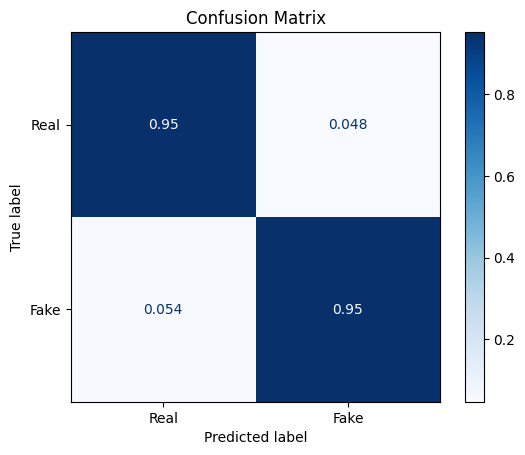

In [30]:
# Compute confusion matrix and normalize
cm = confusion_matrix(test_labels, preds, normalize='true')

# Define class names (0: Real, 1: Fake)
class_names = ['Real', 'Fake']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

output_path = '/content/drive/My Drive/confusion_matrix_bert_svm.png'
plt.savefig(output_path)

plt.show()

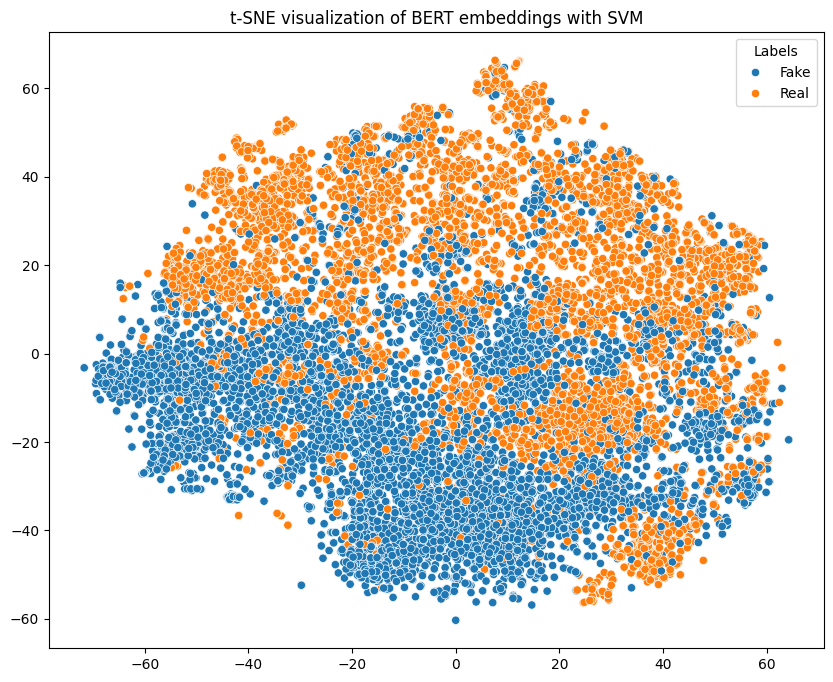

In [29]:
tsne = openTSNE.TSNE(n_components=2, initialization="random", perplexity=30, n_iter=300, random_state = 1)
test_embeddings_2D = tsne.fit(test_embeddings)

class_names = ['Real', 'Fake']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=test_embeddings_2D[:, 0], y=test_embeddings_2D[:, 1], hue=[class_names[id] for id in preds])
plt.title('t-SNE visualization of BERT embeddings with SVM')
plt.legend(title='Labels')
bert_knn_path = '/content/drive/My Drive/bert_svm.png'
plt.savefig(bert_knn_path)
plt.show()

# TF-IDF

## TF-IDF & KNN

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Preprocess
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)


In [ ]:
en_data['combined_cleaned'] = (en_data['title'] + ' ' + en_data['text']).apply(preprocess)

In [ ]:
en_data['combined_cleaned'].head()

In [ ]:
vectorizer_tfidf = TfidfVectorizer(ngram_range = (1,2), use_idf=True)

In [ ]:
# Convert text to TF-IDF vectors
X = vectorizer_tfidf.fit_transform(df['combined_cleaned'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

## TF-IDF & SVM

# Word2Vec

## Word2Vec & KNN

## Word2Vec & SVM